In [32]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.special import expn
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
save = False
plt.rcParams.update({"text.usetex": True,'font.family': 'serif','font.size':10})

In [199]:
# Parameters
numslices = 10
N = 128
srcplane = 63
boxsize = 22685/10 # comoving kpc, # /10 since in analytical solution assumes a = 1 at z = 9
dr = boxsize / N

In [200]:
files_coarse = []
files_fine = []
prefix = "./"
for k in range(11):
    files_coarse.append(prefix + f"results_coarse/xfrac_{k:n}.pkl")
for k in range(101):
    files_fine.append(prefix + f"results_fine/xfrac_{k:n}.pkl")

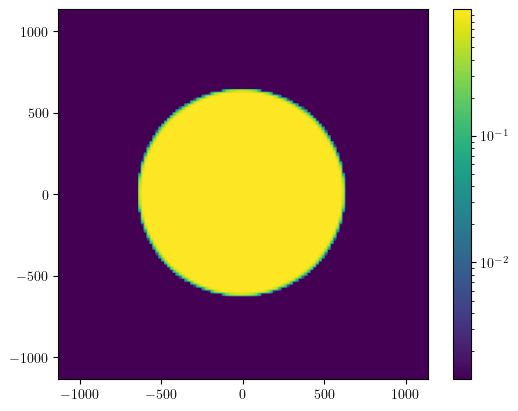

In [201]:
with open(files_coarse[4],"rb") as f:
    xtest = pkl.load(f)
plt.imshow(xtest[:,:,srcplane],norm='log',extent=(-boxsize/2,boxsize/2,-boxsize/2,boxsize/2))
plt.colorbar()

In [202]:
slices_coarse = np.empty((len(files_coarse),int(N/2)+1))
for i,fn in enumerate(files_coarse):
    with open(fn,"rb") as f:
        slices_coarse[i] = pkl.load(f)[srcplane:,srcplane,srcplane]
slices_fine = np.empty((len(files_fine),int(N/2)+1))
for i,fn in enumerate(files_fine):
    with open(fn,"rb") as f:
        slices_fine[i] = pkl.load(f)[srcplane:,srcplane,srcplane]

In [230]:
# Analytical Solution
kpc = 3.086e21
year = 3.15576E+07
Ngamma = 1e54
nH = 1.87e-4
alpha_B = 2.59e-13

kpc_in_km = 3.0857e16 # km
myr_in_s = 31557600000000 # s

cosmology = FlatLambdaCDM(70, 0.27,2.726, Ob0=0.043)
ti = cosmology.age(9).to('Myr').value

r_S = ((3*Ngamma)/(4*np.pi*alpha_B*nH**2))**(1./3) / kpc
t_rec = 1.0 / (alpha_B*nH*year*1e6)
lam = ti / t_rec
print(lam)
print(ti)
print("r_S = ",r_S," kpc")
print("t_rec = ",t_rec," Myr")
def y(t):
    return lam*np.exp(lam*ti/t)*(t/ti*expn(2,lam*ti/t) - expn(2,lam))
def r_I(t):
    return r_S*(y(ti+t))**(1./3)
def r_I_noncosmo(t):
    return r_S * (1.0 - np.exp(-t/t_rec))**(1./3)
def v_I(t):
    return kpc_in_km/myr_in_s * r_S/(3*t_rec) * (np.exp(-t/t_rec))/(1.0 - np.exp(-t/t_rec))**(2./3)

0.862007470892602
563.9825828256307
r_S =  964.3770859478684  kpc
t_rec =  654.2664673678886  Myr


In [204]:
r_I(500)

837.6080388283052

In [205]:
tt = np.linspace(0,500,200,endpoint=True)
tt_ = np.linspace(0,500,11,endpoint=True)
tt_fine = np.linspace(0,500,101,endpoint=True)
r_analytical = r_I(tt)
v_analytical = v_I(tt[1:])

In [207]:
x = np.linspace(0,boxsize/2,int(N/2)+1)

In [208]:
# Find position of ionization front by interpolation
# flip() is used because np.interp works on monotonically increasing functions only
front_pos_coarse = np.empty(11)
front_pos_fine = np.empty(len(files_fine))
for k in range(11):
    front_pos_coarse[k] = np.interp(0.5,np.flip(slices_coarse[k]),np.flip(x))
for k in range(len(files_fine)):
    front_pos_fine[k] = np.interp(0.5,np.flip(slices_fine[k]),np.flip(x))

In [209]:
front_pos_coarse

array([  0.        , 399.42403426, 502.23212487, 571.48004296,
       625.99478775, 668.49276733, 710.4242086 , 745.95880316,
       776.11052352, 806.46190095, 835.11597091])

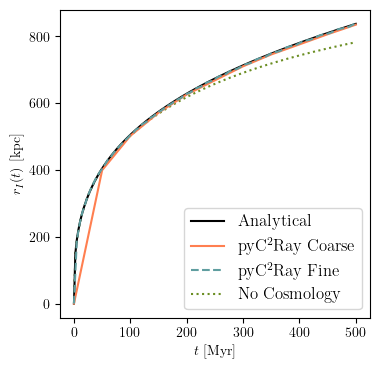

In [244]:
fig3, ax3 = plt.subplots(figsize=(4,4))
offset = 7
l_nc, = ax3.plot(tt,r_I_noncosmo(tt),':',color='olivedrab',label="No Cosmology")
l_an, = ax3.plot(tt,r_analytical,color='black',label="Analytical")
l_coarse, = ax3.plot(tt_,front_pos_coarse,'-',ms=5,label="pyC$^2$Ray Coarse",color='coral')
l_fine, = ax3.plot(tt_fine,front_pos_fine,'--',ms=5,label="pyC$^2$Ray Fine",color='cadetblue')
ax3.set_xlabel("$t$ [Myr]")
ax3.set_ylabel("$r_I(t)$ [kpc]")
ax3.legend(fontsize=12,handles=[l_an,l_coarse,l_fine,l_nc])
if save: fig3.savefig("time_plot.png",dpi=300,bbox_inches='tight')

In [184]:
# convert to km/s

#front_vel_coarse = kpc_in_km/myr_in_s * np.diff(front_pos_coarse) / np.diff(tt_)
#front_vel_fine = np.diff(front_pos_fine) / np.diff(tt_fine)
t_ave = []
t_ave_fine = []
front_vel_fine = []
front_vel_coarse = []
for k in range(1,len(tt_)):
    j = 1
    while (front_pos_coarse[k]-front_pos_coarse[k-j]) < dr:
        j+=1
    front_vel_coarse.append(kpc_in_km/myr_in_s * (front_pos_coarse[k]-front_pos_coarse[k-j]) / (tt_[k]-tt_[k-j]))
    tavei = (tt_[k]+tt_[k-j])/2
    t_ave.append(tavei)
for k in range(1,len(tt_fine)):
    j = 1
    while (front_pos_fine[k]-front_pos_fine[k-j]) < dr:
        j+=1
    front_vel_fine.append(kpc_in_km/myr_in_s * (front_pos_fine[k]-front_pos_fine[k-j]) / (tt_fine[k]-tt_fine[k-j]))
    #tavei = (tt_fine[k]+tt_fine[k-1])/2
    tavei = (tt_fine[k]+tt_fine[k-j])/2
    t_ave_fine.append(tavei)

In [ ]:
fig4, ax4 = plt.subplots(figsize=(4,4))
offset = 7
ax4.semilogy(tt[1:],v_analytical,color='black',label="Analytical")
ax4.semilogy(t_ave,front_vel_coarse,'o',label="pyC$^2$Ray Coarse",color='coral')
ax4.set_xlabel("$t$ [Myr]")
ax4.set_ylabel("$v_I(t)$ [kpc]")
ax4.legend()
if save: fig4.savefig("time_plot_vel.png",dpi=300,bbox_inches='tight')

In [212]:
raderr_coarse = front_pos_coarse[1:] / r_I(tt_[1:])
raderr_fine = front_pos_fine[1:] / r_I(tt_fine[1:])

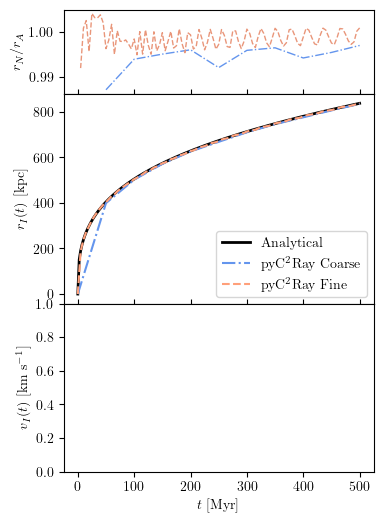

In [224]:
fig, ax = plt.subplots(3,1,figsize=(4,6),sharex=True,height_ratios=[2,5,4])

#ax[0].axhline(1,color='black')
ax[0].plot(tt_[1:],raderr_coarse,'-.',lw=1,label="pyC$^2$Ray Coarse",color='cornflowerblue')
ax[0].plot(tt_fine[1:],raderr_fine,'--',lw=1,color='darksalmon')
yspac = 0.013
ax[0].set_ylabel("$r_{N}/r_{A}$")
#ax[0].set_ylim(1-yspac,1+yspac)

ax[1].plot(tt,r_analytical,color='black',label="Analytical",lw=2)
ax[1].plot(tt_,front_pos_coarse,'-.',label="pyC$^2$Ray Coarse",color='cornflowerblue')
ax[1].plot(tt_fine,front_pos_fine,'--',ms=6,label="pyC$^2$Ray Fine",color='lightsalmon')


#ax[0].set_xlabel("$t$ [Myr]")
ax[1].set_ylabel("$r_I(t)$ [kpc]")
ax[1].tick_params(top=True)
ax[1].legend()

#ax[2].semilogy(tt[1:],v_analytical,color='black',label="Analytical",lw=2)
#ax[2].semilogy(t_ave,front_vel_coarse,'-.',label="pyC$^2$Ray Coarse",color='cornflowerblue')
#ax[2].semilogy(t_ave_fine,front_vel_fine,'--',label="pyC$^2$Ray Fine",color='lightsalmon')

#ax[1].semilogy(tt_,front_vel_coarse,'^',label="pyC$^2$Ray Coarse",color='teal')

ax[2].set_xlabel("$t$ [Myr]")
ax[2].set_ylabel("$v_I(t)$ [km s$^{-1}$]")
ax[2].tick_params(top=True)
#ax[1].legend()
fig.subplots_adjust(hspace=0)

In [23]:
fig.savefig('test1.eps',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


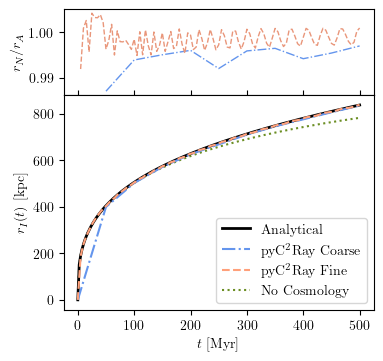

In [246]:
fig, ax = plt.subplots(2,1,figsize=(4,3.9),sharex=True,height_ratios=[2,5])

#ax[0].axhline(1,color='black')
ax[0].plot(tt_[1:],raderr_coarse,'-.',lw=1,label="pyC$^2$Ray Coarse",color='cornflowerblue')
ax[0].plot(tt_fine[1:],raderr_fine,'--',lw=1,color='darksalmon')
yspac = 0.013
ax[0].set_ylabel("$r_{N}/r_{A}$")
#ax[0].set_ylim(1-yspac,1+yspac)

l_nc, = ax[1].plot(tt,r_I_noncosmo(tt),':',color='olivedrab',label="No Cosmology")
l_an, = ax[1].plot(tt,r_analytical,color='black',label="Analytical",lw=2)
l_coarse, = ax[1].plot(tt_,front_pos_coarse,'-.',label="pyC$^2$Ray Coarse",color='cornflowerblue')
l_fine, = ax[1].plot(tt_fine,front_pos_fine,'--',ms=6,label="pyC$^2$Ray Fine",color='lightsalmon')


#ax[0].set_xlabel("$t$ [Myr]")
ax[1].set_ylabel("$r_I(t)$ [kpc]")
ax[1].tick_params(top=True)
ax[1].legend(handles=[l_an,l_coarse,l_fine,l_nc])

#ax[1].semilogy(tt_,front_vel_coarse,'^',label="pyC$^2$Ray Coarse",color='teal')

ax[1].set_xlabel("$t$ [Myr]")
ax[1].tick_params(top=True)
#ax[1].legend()
fig.subplots_adjust(hspace=0)

In [247]:
fig.savefig("test4.eps",bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
